In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from solardatatools import DataHandler
from solardatatools.dataio import load_redshift_data
from solardatatools.algorithms import Dilation
from spcqe.quantiles import SmoothPeriodicQuantiles

## With PV data

Data import

In [3]:
query = {
'siteid': "TADBC1078041",
'api_key': os.environ.get('REDSHIFT_API_KEY'),
'sensor': 0
}
df = load_redshift_data(**query)
dh = DataHandler(df, convert_to_ts=True)
dh.run_pipeline()

/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/time_axis_manipulation.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  meas_name = str(df_view[name_key][0])



            *********************************************
            * Solar Data Tools Data Onboarding Pipeline *
            *********************************************

            This pipeline runs a series of preprocessing, cleaning, and quality
            control tasks on stand-alone PV power or irradiance time series data.
            After the pipeline is run, the data may be plotted, filtered, or
            further analyzed.

            Authors: Bennet Meyers and Sara Miskovich, SLAC

            (Tip: if you have a mosek [https://www.mosek.com/] license and have it
            installed on your system, try setting solver='MOSEK' for a speedup)

            This material is based upon work supported by the U.S. Department
            of Energy's Office of Energy Efficiency and Renewable Energy (EERE)
            under the Solar Energy Technologies Office Award Number 38529.

            


task list:   0%|                                          | 0/7 [00:00<?, ?it/s]/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/time_axis_manipulation.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if avg_day[0] >= thresh:
/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/time_axis_manipulation.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if avg_day[-1] >= thresh:
task list:  14%|████▊                             | 1/7 [00:00<00:01,  4.39it/s]/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/matrix_



total time: 51.49 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              12.74s
Cleaning                   0.64s
Filtering/Summarizing      38.11s
    Data quality           0.36s
    Clear day detect       0.83s
    Clipping detect        19.27s
    Capacity change detect 17.65s



Data dilation

In [4]:
nvals_dil = 101
dil = Dilation(dh)
sig = dil.signal_dil
ndays = len(sig) // nvals_dil

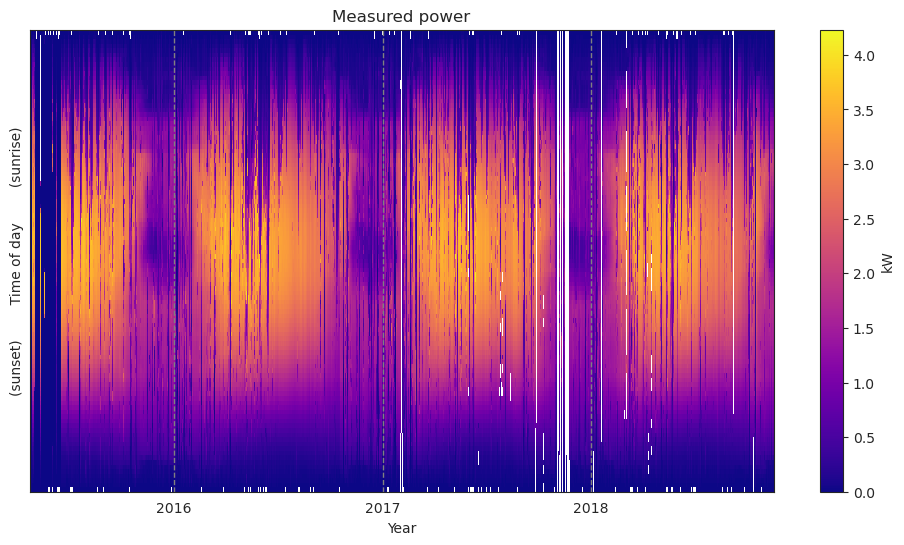

In [5]:
dil.plot_heatmap(space='dilated');

fit quantiles

In [15]:
my_quantiles = [0.02, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.98]

In [16]:
spq1 = SmoothPeriodicQuantiles(
        num_harmonics=[10,3],
        periods=[nvals_dil, 365.24225*nvals_dil],
        standing_wave=[True, False],
        trend=False,
        quantiles=my_quantiles,
        weight=10,
        problem='sequential',
        solver='osd'
)
spq1.fit(sig)

100%|███████████████████████████████████████████| 11/11 [17:34<00:00, 95.89s/it]


In [17]:
spq2 = SmoothPeriodicQuantiles(
        num_harmonics=[10,3],
        periods=[nvals_dil, 365.24225*nvals_dil],
        standing_wave=[True, False],
        trend=False,
        quantiles=my_quantiles,
        weight=10,
        problem='full',
        solver='mosek'
)
spq2.fit(sig)

In [18]:
spq3 = SmoothPeriodicQuantiles(
        num_harmonics=[10,3],
        periods=[nvals_dil, 365.24225*nvals_dil],
        standing_wave=[True, False],
        trend=False,
        quantiles=my_quantiles,
        weight=10,
        problem='sequential',
        solver='mosek'
)
spq3.fit(sig)

100%|███████████████████████████████████████████| 11/11 [17:17<00:00, 94.32s/it]


plot quantile heatmaps

In [19]:
def plot_quantiles(q, fq, sig):
    nq = fq.shape[1]
    nrows = (nq + 2) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(12, 3*nrows))
    for i in range(len(q)):
        sns.heatmap(fq[1:, i].reshape((nvals_dil, ndays), order='F'), ax=ax[i//2, i%2], cmap='plasma')
        ax[i//2, i%2].set_title(f'Quantile {q[i]}')
    sns.heatmap(sig[1:].reshape((nvals_dil, ndays), order='F'), ax=ax[-1, -1], cmap='plasma')
    ax[-1, -1].set_title('Dilated signal')
    plt.tight_layout()
    return plt.gca()

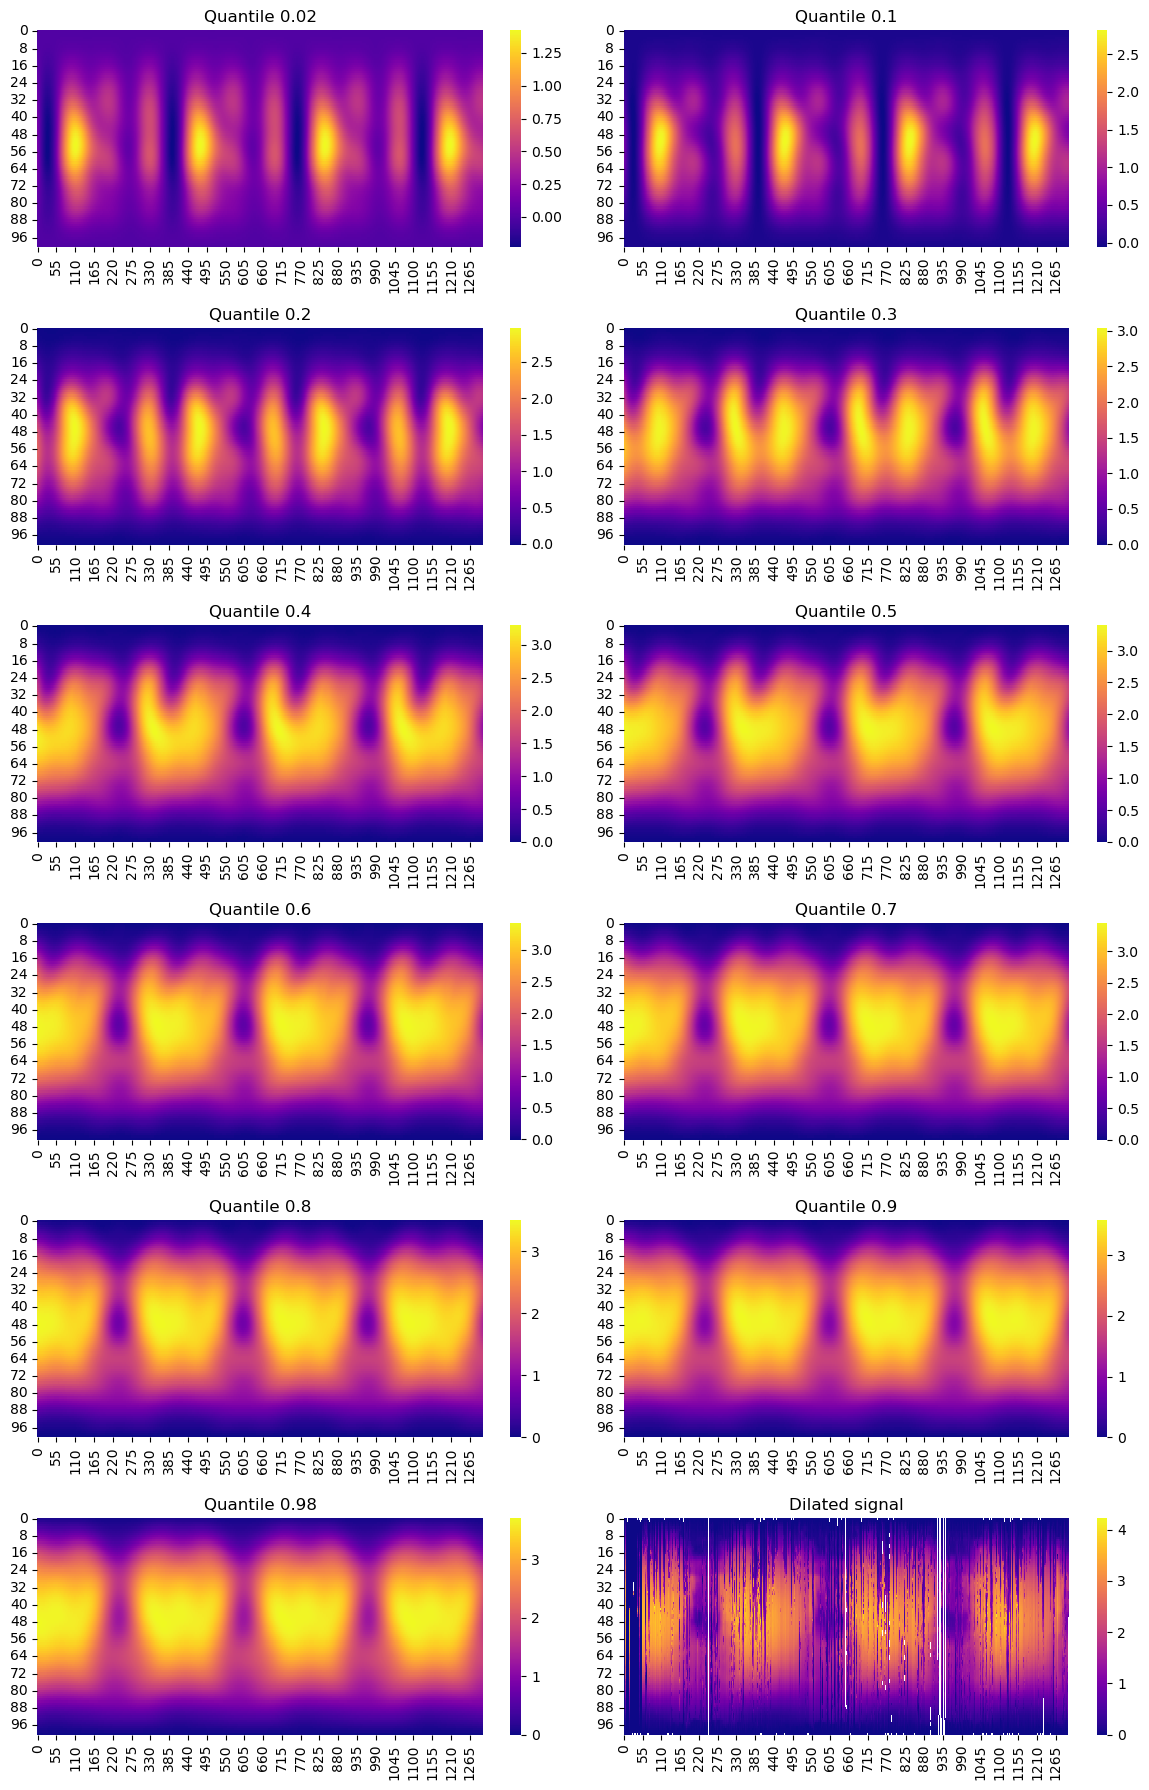

In [20]:
plot_quantiles(my_quantiles, spq1.fit_quantiles, sig);

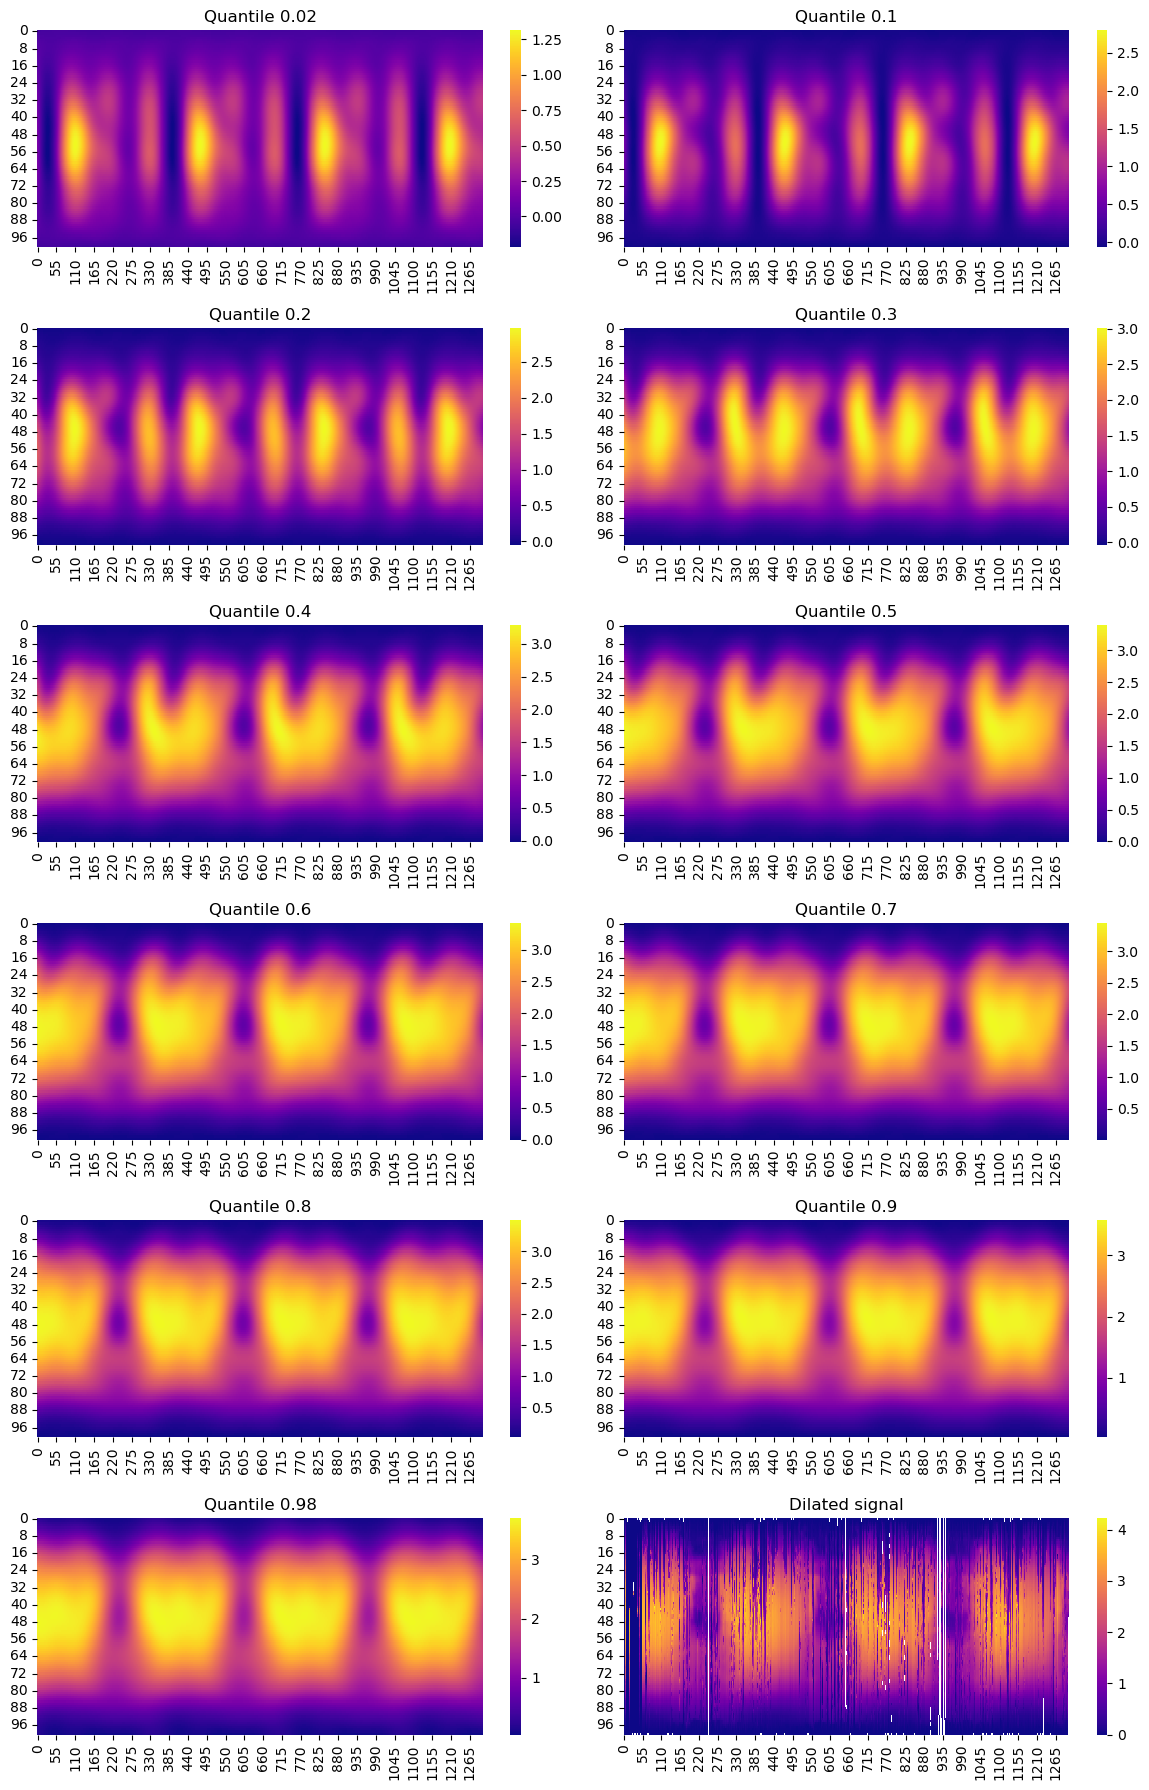

In [21]:
plot_quantiles(my_quantiles, spq2.fit_quantiles, sig);

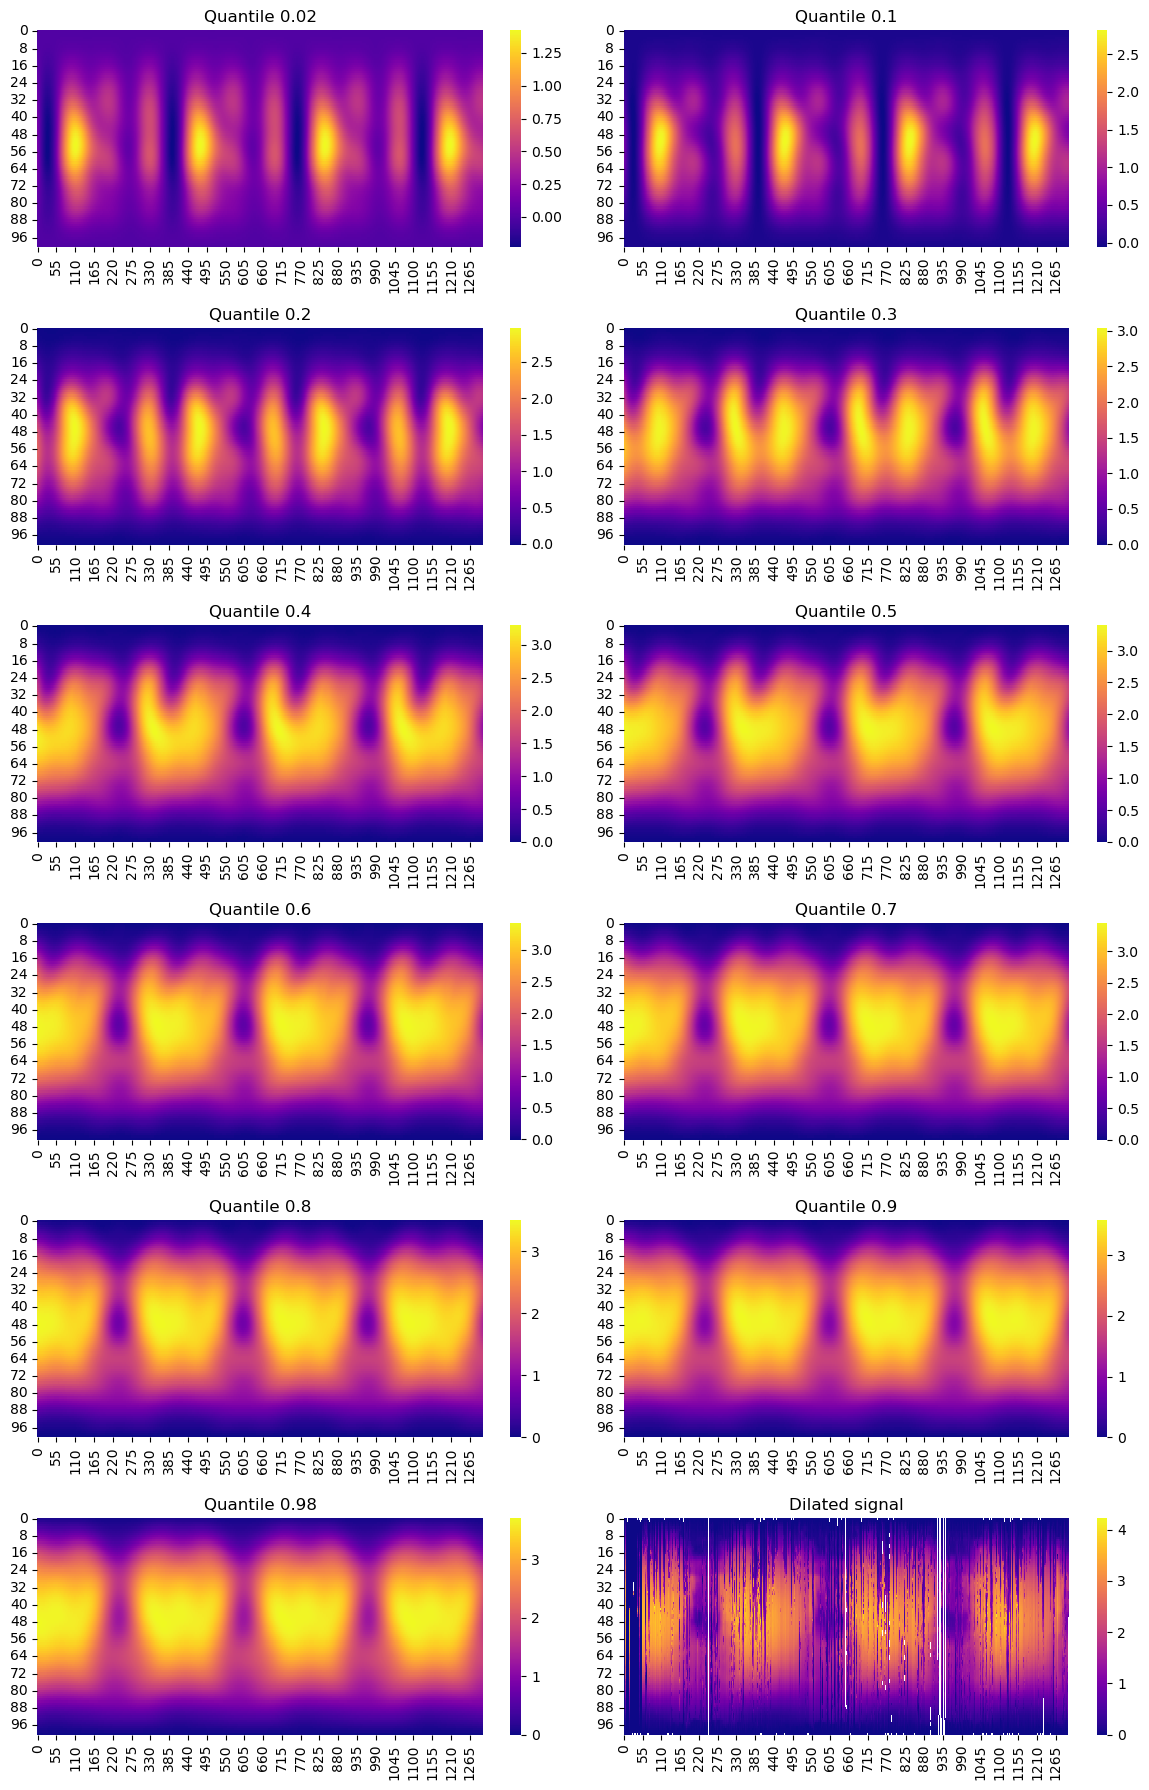

: 

In [22]:
plot_quantiles(my_quantiles, spq3.fit_quantiles, sig);